# 게임 산업 영향 시뮬레이션
## 개요
* 2020년 12월 - 2021년 2월
* 김태경, 광운대학교 경영학부 부교수
* 게임산업 영향 시뮬레이션
* 간소화 버전

## 코드

### 모듈

In [1]:
import random

import mesa
from mesa import Agent,Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 전역 파라미터

질병코드가 도입된다. 영향은 뭘까?

1. **게임 인식 악화** 게임에 대한 인식 악화, 단순히 게임을 피하게 될 것.
1. **게임 행위 제제** 외력에 의한 게임 사용 제제가 강제될 수 있을 것.
1. **게임세 도입** 질병 치유를 위한 목적으로 게임세를 내야 할 수도

세팅
1. **게임 인식 악화** -> 게임을 하기 위한 toss 확률 변화
1. **행위 제제** -> INSPECTION 상승
1. **게임세 도입** -> TAX 부과로 spending 상각

In [38]:
ISOLATION_DURATION=7 #isolated for a week
TICKET_REGEN_MAX=8 #regenerating tickets
TICKET_REGEN_TICK=2 #ticket regen ticks
TICKET_PURCHASE_P=0.01
SEARCH_SPACE_X=10
SEARCH_SPACE_Y=10
NUM_PLAYERS=1000
NUM_GAME_TIME=365*5 #five years
FLOW_THRESHOLD=365*1 #one year experience
FLOW_P=0.02 #probability of getting in flow
INITIAL_FLOW=0.02 #2 percent
CURE_DURATION=7
LOSS_EXP=CURE_DURATION*4
GAME_FUN_LOSS=0.0001
SPENDING_UNIT=10000
#
RETRY=5 #게임 상대를 찾는 횟수(최대)

질병코드 도입=1, 도입 안함=0 컨트롤

In [39]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입

GAMING_P=0.5 #gaming intention 1/2
INSPECTION=0.02 #inspection rate 2% up
SPENDING_DESC=(1-0.74) #담배 세금은 전체의 74%

### 유틸리티 함수

In [4]:
## 게임 그룹을 생성
# P2pGame

def make_group(inlist,size):
    items=inlist[:]
    random.shuffle(items) #item shuffle
    gid=1
    result={}
    while len(items)>0:
        r=[]
        for _ in range(size):
            try:
                r.append(items.pop(0))
            except:
                break
        if len(r)>0:
            result[gid]=r
            gid+=1
    return result

In [5]:
def fun_loss(tick):
    p=tick/NUM_GAME_TIME
    if p<0.1:
        return 1.0
    elif p>=0.1 and p<0.2:
        return -1*p+1.1
    elif p>=0.2 and p<0.4:
        return -3*p+1.5
    elif p>=0.4 and p<0.6:
        return -1.5*p+0.9
    else:
        return 0.0

In [6]:
x=np.arange(NUM_GAME_TIME)
f=np.vectorize(fun_loss)
y=f(x)

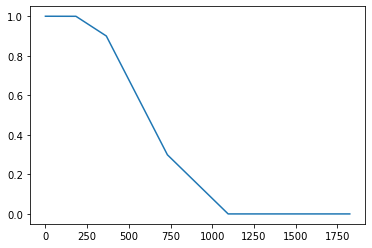

In [7]:
plt.plot(x,y)
plt.show()

## 게임 사용자

In [9]:
class Gamer1(Agent):
    def __init__(self,unique_id,model,moore=True):
        super().__init__(unique_id,model)
        self.moore=moore
        self.model=model
        self.flow=0 #1=flow, 0=not flow
        self.spending=0 #game spending
        self.active=1 #active gamer
        #Global -----------------------------------
        self.exp=0 #game experience
        #parameter for P2M ------------------------
        self.ticket=0 #game ticket,(P2m)
        self.ticket_regen_time=TICKET_REGEN_TICK
        #parameter for P2P ------------------------
        self.isolated=0 #
        self.isolated_duration=0

# = 게이머의 행동 결정 프로세스
    def step(self):
        self.reset_spending() #현재 시점의 spending reset
        if self.check_game_continue(): #게임에 대한 흥미를 잃었나? 확인
            return #흥미를 잃었다면 그만둔다.
        self.ticket_regen_time-=1 #게임 접속 무료티켓 1개 감소(게임 접속)
        if TRT_PERCEPTION==0 or self.model.toss(GAMING_P): #부정적 인식 없거나, 있으면 게임 참여를 위해 주사위 던지기
            if self.recover(): #격리가 없을 경우
                self.play_game()  #게임 플레이
                self.get_free_ticket() #무료 티켓을 다시 받는다.
        self.be_loyal_player() #게임 사용자의 involvement (addiction or flow) 결정
# == 게임을 계속할 의사가 있을까 결정
    def check_game_continue(self):
        if self.model.toss(fun_loss(self.model.tick)): #비선형 fun_loss()함수 소환 -> 게임 출시 시간에 따라 흥미 결정
            self.active=1 #흥미의 결정 확률은 비선형적으로 줄어든다. 흥미가 있으면 active=1
        else:
            self.active=0 #흥미를 잃었다.
        return self.active==0 #게임에 흥미를 잃었나? True, False
# == 당기의 지출액 리셋
    def reset_spending(self):
        self.spending=0
    def contribution_game_company(self):
        #SPENDING_UNIT은 1회 지출규모(단위 금액 - 시뮬레이션에 오해가 많아서 단위 조정을 해야 할 듯.
        #SPENDING_DESC는 0과 1사이. 게임회사가 정액 세율을 x 이면 (1-x)가 SPENDING_DESC
        return SPENDING_UNIT*(SPENDING_DESC if TRT_TAX else 1)
# == 게임 플레이
    def play_game(self):
        if self.ticket > 0: #플레이 티켓이 있을 경우
            self.ticket-=1 #티켓을 주고 플레이
            self.exp+=1 #경험치가 쌓인다. 경험치는 flow 결정에 장기적 영향
        else: #티켓이 모두 소진되었다면?
            if self.flow: #flow상태인가?
                self.spending=self.contribution_game_company() #구매 결정이 게임사에 주는 이익
            else: #flow상태가 아니다.
                if self.model.toss(TICKET_PURCHASE_P): #티켓 구매 의사결정의 확률(유료 아이템 구매 확률)
                    self.spending=self.contribution_game_company() #구매 결정이 게임사에 주는 이익
# == 무료 게임 티켓을 받기
    def get_free_ticket(self):
        if self.ticket_regen_time<=0: #티켓 무료 배포기간이 지났다면
            self.refresh() #게임 상태 리프레쉬!
# == 로열 플레이어(flow) 탄생시키기
    def be_loyal_player(self):
        if self.recover(): #강제 격리가 없을 경우
            if self.exp >= FLOW_THRESHOLD: #흥미 기준은 경험치
                if self.model.toss(FLOW_P): #주사위를 던져 의사결정을 한다.
                    self.flow=1 #과몰입 상태(티켓이 필요하면 사고, 아이템은 따라 구매한다)
    def recover(self): #강제 격리가 있을 경우
        if self.isolated:
            if self.isolated_duration<=0:
                self.isolated=0
                self.isolated_duration=0
                self.refresh()
                return True
            else:
                self.isolated_duration-=1
            return False
        return True
# == 게임 과몰입으로 격리 조치될 경우(게임 질병 코드 부여시)
    def isolate(self):
        self.flow=0 #과몰입 해제
        self.isolated=1 #격리 마크(낙인)
        self.ticket=0 #참가 티켓 몰수
        self.isolated_duration=CURE_DURATION #치료 기간만큼 격리 기간 설정(매 기간 -1씩)
        self.exp-=LOSS_EXP #경험치 일몰
        #경험치 일몰은 최대 exp=0까지만 허용
        if self.exp<0:
            self.exp=0
# == 과몰입 치료(게임 질병 코드 부여시)
    def cure(self):
        self.isolated-=1 #치료
# == 티켓 리프레쉬
    def refresh(self):
        #TODO - 게임 티켓 리젠 결정을 좀더 봐야
        self.ticket=self.random.choice(list(range(1,TICKET_REGEN_MAX)))
        self.ticket_regen_time=TICKET_REGEN_TICK

In [14]:
class Gamer2(Gamer1):
    def __init__(self,unique_id,model,moore=True):
        super().__init__(unique_id,model,moore) #Gamer
# = 게이머의 행동 결정 프로세스
    def step(self):
        self.reset_spending() #현재 시점의 spending reset
        if self.check_game_continue(): #게임에 대한 흥미를 잃었나? 확인
            return #흥미를 잃었다면 그만둔다.
        self.ticket_regen_time-=1 #게임 접속 무료티켓 1개 감소(게임 접속)
        if self.check_buddy():
            if TRT_PERCEPTION==0 or self.model.toss(GAMING_P): #부정적 인식 없거나, 있으면 게임 참여를 위해 주사위 던지기
                if self.recover(): #격리가 없을 경우
                    self.play_game()  #게임 플레이
                    self.get_free_ticket() #무료 티켓을 다시 받는다.
            self.be_loyal_player() #게임 사용자의 involvement (addiction or flow) 결정
# == 플레이할 상대편이 존재하는가를 검사
    def check_buddy(self):
        #상대방을 선택할 수 있는가?
        mates=self.model.grid.get_cell_list_contents([self.pos,]) #같은 위치에서 상대를 고른다.
        trial=0
        while trial < RETRY:
            trial+=1
            if len(mates)>1:
                other=self.random.choice(mates) #pick one
                if self.unique_id != other.unique_id: #다른 사람
                    if other.isolated==0 and other.active==1: #격리 아니고 아직 게임을 하면
                        return True #게임을 시작할 수 있다.
                break
            else: #no one here
                x=self.model.random.randrange(self.model.grid.width)
                y=self.model.random.randrange(self.model.grid.height)
                self.model.grid.place_agent(self,(x,y,)) #다른 위치로 이동
        return False #상대를 찾지 못하기 때문에 게임을 할 수 없다.

## 게임
### 게임 종류에 따라

1. 캐주얼 게임 - 티켓 구매해서 그냥 혼자 수행
1. 웹보드 게임 - 대전 상대를 랜덤하게 선택하여 수행(상대방 필요)
1. MMOPRG - 파티 구성해서 그냥 혼자/단체 수행(상대방 필요)
1. FPS/대전형 게임 - 파티 구성해서 실행(상대방 필요)

간단하게 변경하면?

1. 대전상대가 필요없는 경우/대전상대가 필요한 경우



In [11]:
class Game(Model):
# = 게임 세계의 천지창조
    def __init__(self,N,width,height,gamer_type=1):
        #N - 게임사용자(처음부터 full이라고 가정, 게임의 신규 사용자는 없음)
        #width, height - 격리(질병코드 부과 시) 시 대상자 탐색 공간의 크기, 전수 조사하는 것을 원칙, 사실 의미는 없음
        #gamer_type, (=1 혼자 플레이, =2 협동 플레이)
        self.tick=0 #게임 시간
        self.num_agents=N #게임사용자
        self.gamer_type=gamer_type #게임 사용자 타입
        self.schedule=RandomActivation(self) #시간 개념 창조(ABM 위해)
        self.grid=MultiGrid(width,height,True) #공간 개념 창조(의미는 없음 - ABM보다는 MCMC에 가까움)
        self.join_game() #게임 참가, 모든 잠재적 사용자가 일단 게임에 참가함
        self.register_data_collector() #게임 데이터 수집기 생성하고 등록함
# = 게임 세계의 불확실성 컨트롤
    def toss(self,p=0.5): #stochastic process에 따라 처리
        return self.random.random() <= p #일양분포 가정
# == 게임 참가
    def join_game(self):
        N=self.num_agents
        for i in range(N):
            self.hatch(i) #agent 부화 
# = 게임 사용자 탄생(부화)
    def hatch(self,unique_id):
        if self.gamer_type==1:
            gamer=Gamer1(unique_id,self) #단독 게임 사용자
        elif self.gamer_type==2:
            gamer=Gamer2(unique_id,self) #협동 게임 사용자
        else:
            gamer=Gamer1(unique_id,self) #기본값은 단독 게임 사용자
        self.inbound_flow_gamer(gamer) #과몰입 사용자 유입 결정
        self.relationship(gamer) #게임과 게임 사용자의 최초 관계 설정
        self.make_gamer_alive(gamer) #게임 사용자를 게임 세계에 위치
# == 게임 사용자와 게임과의 관계 설정
    def relationship(self,gamer):
        gamer.ticket=self.random.choice(list(range(1,TICKET_REGEN_MAX))) #티켓 배포
# == 게임 사용자를 게임 세계에 위치
    def make_gamer_alive(self,gamer):
        self.schedule.add(gamer) #시간 부여
        x=self.random.randrange(self.grid.width) #공간 부여할 x
        y=self.random.randrange(self.grid.height) #공간 부여할 y
        self.grid.place_agent(gamer,(x,y,)) #공간 위에 agent 위치
# == 과몰입 사용자의 유입
    def inbound_flow_gamer(self,gamer):
        if self.toss(p=INITIAL_FLOW): #과몰입 사용자 유입확률에 따라
            gamer.flow=1 #과몰입 사용자 유입
# == 무슨 데이터를 살펴볼 것인지 등록
    def register_data_collector(self):
        self.datacollector=DataCollector(
            agent_reporters={"Spending":"spending","Flow":"flow"}
        )
# == 검사(질병코드 있을 때)
    def inspect(self):
        for cell in self.grid.coord_iter(): #visit places
            if self.toss(INSPECTION): #현재 위치를 검사할 것인지를 결정함
                content,x,y=cell
                for gamer in content: #게임 사용자에 대해
                    if gamer.flow: #flow이면
                        gamer.isolate() #격리한다.
# == 시간을 지나가게 하기
    def step(self,i):
        #i = tick(시뮬레이션 시간)
        self.tick=i #tick 저장
        self.datacollector.collect(self) #데이터 수집
        #== 행위자
        self.schedule.step() #게임 사용자들이 시간 보내기
        #=== 환경
        if TRT_FORCE: #질병코드 효과 있을 때
            self.inspect() #강제 검사/격리/치료

# 시뮬레이션 수행 준비

## Simulation

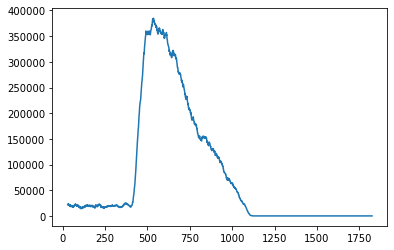

In [71]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,1)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)

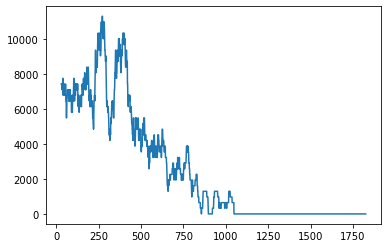

In [76]:
TRT_PERCEPTION=1 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,1)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)

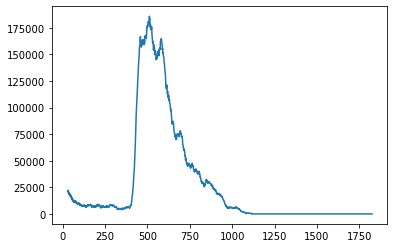

In [73]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=1 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,1)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)

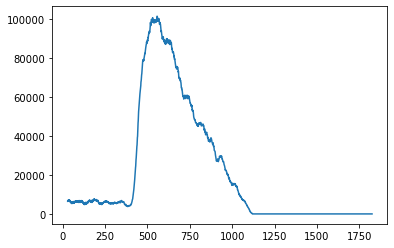

In [74]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=1 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,1)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)

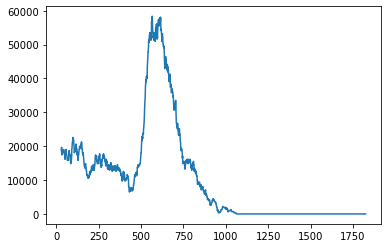

In [68]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,2)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)

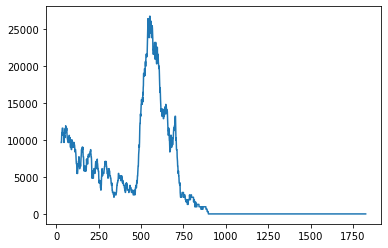

In [70]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=1 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=Game(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y,2)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
y=p.groupby('Step')['Spending'].sum().rolling(window=31).mean()
plt.plot(y)